<a href="https://colab.research.google.com/github/abnan/ODECME/blob/master/ODECME_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from skimage import io
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import shutil
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from skimage.transform import pyramid_gaussian
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.filters import sobel
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.morphology import square
from skimage.morphology import dilation
from torch.autograd import Function

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


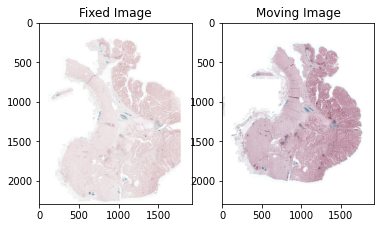

In [2]:
I = io.imread("fixed.jpeg").astype(np.float32)/255.0 # fixed image
J = io.imread("moving.jpeg").astype(np.float32)/255.0 # moving image

downscale = 2.0
ifplot=True
if np.ndim(I) == 3:
  nChannel=I.shape[2]
  pyramid_I = tuple(pyramid_gaussian(gaussian(I, sigma=1, multichannel=True), downscale=downscale, multichannel=True))
  pyramid_J = tuple(pyramid_gaussian(gaussian(J, sigma=1, multichannel=True), downscale=downscale, multichannel=True))
elif np.ndim(I) == 2:
  nChannel=1
  pyramid_I = tuple(pyramid_gaussian(gaussian(I, sigma=1, multichannel=False), downscale=downscale, multichannel=False))
  pyramid_J = tuple(pyramid_gaussian(gaussian(J, sigma=1, multichannel=False), downscale=downscale, multichannel=False))
else:
  print("Unknown rank for an image")
  ifplot = False

if ifplot:
  %matplotlib inline
  fig=plt.figure()
  fig.add_subplot(1,2,1)
  plt.imshow(I)
  plt.title("Fixed Image")
  fig.add_subplot(1,2,2)
  plt.imshow(J)
  plt.title("Moving Image")
  

In [9]:
L = 6 # where registration starts (at the coarsest resolution)
nFraction=0.075
# create a list of necessary objects you will need and commit to GPU
I_lst,J_lst,h_lst,w_lst,xy_lst,ind_lst=[],[],[],[],[],[]
for s in range(L):
  I_, J_ = torch.tensor(pyramid_I[s].astype(np.float32)).to(device), torch.tensor(pyramid_J[s].astype(np.float32)).to(device)
  if nChannel>1:
    I_lst.append(I_.permute(2,0,1))
    J_lst.append(J_.permute(2,0,1))
    h_, w_ = I_lst[s].shape[1], I_lst[s].shape[2]
    ind_ = torch.randperm(h_*w_)[0:int(nFraction*h_*w_)].to(device)
    ind_lst.append(ind_)
  else:
    I_lst.append(I_)
    J_lst.append(J_)
    h_, w_ = I_lst[s].shape[0], I_lst[s].shape[1]
    ind_ = torch.randperm(h_*w_)[0:int(nFraction*h_*w_)].to(device)
    ind_lst.append(ind_)

  print(h_,w_,len(ind_))
  h_lst.append(h_)
  w_lst.append(w_)

  y_, x_ = torch.meshgrid([torch.arange(0,h_).float().to(device), torch.arange(0,w_).float().to(device)])
  y_, x_ = 2.0*y_/(h_-1) - 1.0, 2.0*x_/(w_-1) - 1.0
  xy_ = torch.stack([x_,y_],2)
  xy_lst.append(xy_)

2291 1924 330591
1146 962 82683
573 481 20670
287 241 5187
144 121 1306
72 61 329


In [3]:
B = torch.zeros(8,3,3).to(device)
B[0,0,2] = 1.0
B[1,1,2] = 1.0
B[2,0,1] = 1.0
B[3,1,0] = 1.0
B[4,0,0], B[4,1,1] = 1.0, -1.0
B[5,1,1], B[5,2,2] = -1.0, 1.0
B[6,2,0] = 1.0
B[7,2,1] = 1.0

def MatrixExp(v):
    C = torch.sum(B*v,0)
    A1 = torch.eye(3).to(device)
    A2 = torch.eye(3).to(device)
    H = torch.eye(3).to(device)
    Hinv = torch.eye(3).to(device)
    for i in torch.arange(1,10):
        A1 = torch.mm(A1/i,C)
        H = H + A1
        A2 = torch.mm(A2/i,-C)
        Hinv = Hinv + A2
    return H/H[2,2],Hinv/Hinv[2,2]    


def ComplexMatrixExp(u):
    Cr = torch.sum(B*u[0:8],0)
    Ci = torch.sum(B*u[8:16],0)

    A1r,A2r,A1i,A2i=[],[],[],[]
    A1r.append(torch.eye(3).to(device))
    A1i.append(torch.zeros((3,3)).to(device))
    A2r.append(torch.eye(3).to(device))
    A2i.append(torch.zeros((3,3)).to(device))

    Hr = torch.eye(3).to(device)
    Hi = torch.zeros((3,3)).to(device)
    Hinvr = torch.eye(3).to(device)
    Hinvi = torch.zeros((3,3)).to(device)

    for i in torch.arange(1,20):
        A1r.append(torch.mm(A1r[i-1]/i,Cr)-torch.mm(A1i[i-1]/i,Ci))
        A1i.append(torch.mm(A1r[i-1]/i,Ci)+torch.mm(A1i[i-1]/i,Cr))
        Hr += A1r[i]
        Hi += A1i[i]

        A2r.append(torch.mm(A2r[i-1]/i,-Cr)-torch.mm(A2i[i-1]/i,-Ci))
        A2i.append(torch.mm(A2r[i-1]/i,-Ci)+torch.mm(A2i[i-1]/i,-Cr))
        Hinvr += A2r[i]
        Hinvi += A2i[i]
    return Hr,Hi,Hinvr,Hinvi

In [4]:
n_neurons = 100
class MINE(nn.Module): #https://arxiv.org/abs/1801.04062
  def __init__(self):
    super(MINE, self).__init__()
    self.fc1 = nn.Linear(2*nChannel, n_neurons)
    self.fc2 = nn.Linear(n_neurons, n_neurons)
    self.fc3 = nn.Linear(n_neurons, 1)
    self.bsize = 1 # 1 may be sufficient

  def forward(self, x, ind):

    x = x.view(x.size()[0]*x.size()[1],x.size()[2])
    MI_lb=0.0
    for i in range(self.bsize):
      ind_perm = ind[torch.randperm(len(ind))]
      z1 = self.fc3(F.relu(self.fc2(F.relu(self.fc1(x[ind,:])))))
      z2 = self.fc3(F.relu(self.fc2(F.relu(self.fc1(torch.cat((x[ind,0:nChannel],x[ind_perm,nChannel:2*nChannel]),1))))))

      MI_lb += torch.mean(z1) - torch.log(torch.mean(torch.exp(z2)))
    
    return MI_lb/self.bsize

In [5]:
def PerspectiveWarping(I, H, xv, yv):

  # apply homography
  xvt = (xv*H[0,0]+yv*H[0,1]+H[0,2])/(xv*H[2,0]+yv*H[2,1]+H[2,2])
  yvt = (xv*H[1,0]+yv*H[1,1]+H[1,2])/(xv*H[2,0]+yv*H[2,1]+H[2,2])
  J = F.grid_sample(I,torch.stack([xvt,yvt],2).unsqueeze(0),align_corners=False).squeeze()
  return J

def PerspectiveComplexWarping(I, Hr, Hi, xv, yv):

  xr = xv*Hr[0,0]+yv*Hr[0,1]+Hr[0,2]
  yr = xv*Hr[1,0]+yv*Hr[1,1]+Hr[1,2]
  zr = xv*Hr[2,0]+yv*Hr[2,1]+Hr[2,2]

  xi = xv*Hi[0,0]+yv*Hi[0,1]+Hi[0,2]
  yi = xv*Hi[1,0]+yv*Hi[1,1]+Hi[1,2]
  zi = xv*Hi[2,0]+yv*Hi[2,1]+Hi[2,2]

  xvt = (xr*zr+xi*zi)/(zr**2+zi**2)
  yvt = (yr*zr+yi*zi)/(zr**2+zi**2)
  J = F.grid_sample(I,torch.stack([xvt,yvt],2).unsqueeze(0),align_corners=False).squeeze()
  return J


In [6]:
def multi_resolution_MINE_loss():
  loss=0.0
  params = ode_net()
  for s in np.arange(L-1,-1,-1):
    #ind_lst[s] = torch.randperm(h_lst[s]*w_lst[s])[0:int(nFraction*h_lst[s]*w_lst[s])]
    Hr,Hi,Hinvr,Hinvi = ComplexMatrixExp(params[s].view(16,1,1))
    if nChannel>1:
      Jw_ = PerspectiveComplexWarping(J_lst[s].unsqueeze(0), Hr,Hi, xy_lst[s][:,:,0], xy_lst[s][:,:,1]).squeeze()
      mi = mine_net(torch.cat([I_lst[s],Jw_],0).permute(1,2,0),ind_lst[s])
      #Iw_ = PerspectiveWarping(I_lst[s].unsqueeze(0), Hinv, xy_lst[s][:,:,0], xy_lst[s][:,:,1]).squeeze()
      #mi_inv = mine_net(torch.cat([Iw_,J_lst[s]],0).permute(1,2,0),ind_lst[s])
    else:
      Jw_ = PerspectiveComplexWarping(J_lst[s].unsqueeze(0).unsqueeze(0), Hr,Hi, xy_lst[s][:,:,0], xy_lst[s][:,:,1]).squeeze()
      mi = mine_net(torch.stack([I_lst[s],Jw_],2),ind_lst[s])
      #Iw_ = PerspectiveWarping(I_lst[s].unsqueeze(0).unsqueeze(0), Hinv, xy_lst[s][:,:,0], xy_lst[s][:,:,1]).squeeze()
      #mi_inv = mine_net(torch.stack([Iw_,J_lst[s]],2),ind_lst[s])
    #loss = loss - (1./(2*L))*(mi+mi_inv)
    loss = loss - (1./L)*mi
  return loss

In [7]:
n_neurons = 100
activation = torch.tanh
class ODENet(nn.Module):

  def __init__(self):
    super(ODENet, self).__init__()
    self.fc1 = nn.Linear(17, n_neurons)
    self.fc2 = nn.Linear(n_neurons, 16)
    self.vr = torch.nn.Parameter(torch.zeros(8).to(device), requires_grad=True)
    self.vi = torch.nn.Parameter(torch.zeros(8).to(device), requires_grad=True)
    self.f = 1./torch.pow(downscale, torch.linspace(0,L-1,L)).to(device)
    
    self.vr.data.uniform_(-1e-5,1e-5)
    self.vi.data.uniform_(-1e-5,1e-5)

    self.fc1.weight.data.fill_(0.0)
    self.fc1.bias.data.fill_(0.0)

    self.fc2.weight.data.fill_(0.0)
    self.fc2.bias.data.fill_(0.0)
    
  def forward(self): # Runge-Kutta method

    h = self.f[0:L-1] - self.f[1:L]
    params = torch.zeros(L,16).to(device)
    params[L-1,0:8] = self.vr # initial values are learnable parameters!
    params[L-1,8:16] = self.vi # initial values are learnable parameters!
    for i in np.arange(L-2,-1,-1):
      # Use
      # Runge-Kutta
      k1 = h[i]*self.fc2(activation(self.fc1(torch.cat((self.f[i+1].view(1),params[i+1])))))
      k2 = h[i]*self.fc2(activation(self.fc1(torch.cat((self.f[i+1].view(1)+(1.0/3.0)*h[i],params[i+1]+(1.0/3.0)*k1)))))
      k3 = h[i]*self.fc2(activation(self.fc1(torch.cat((self.f[i+1].view(1)+(2.0/3.0)*h[i],params[i+1]-(1.0/3.0)*k1+k2)))))
      k4 = h[i]*self.fc2(activation(self.fc1(torch.cat((self.f[i].view(1),params[i+1]+k1-k2+k3)))))
      params[i] = params[i+1] + (1.0/8.0)*(k1+3.0*k2+3.0*k3+k4)
      """
      # or, try
      # Euler
      params[i] = params[i+1] + h[i]*self.fc2(activation(self.fc1(torch.cat((self.f[i+1].view(1),params[i+1])))))
      """
    return params

In [10]:
ode_net = ODENet().to(device)
mine_net = MINE().to(device)
optimizer = optim.Adam([{'params': mine_net.parameters(), 'lr': 1e-2},
                        {'params': ode_net.parameters(), 'lr': 1e-3}], amsgrad=True)

for itr in range(1000):
  optimizer.zero_grad()
  loss = multi_resolution_MINE_loss()
  loss.backward(retain_graph=True)
  optimizer.step()
  if itr%100 == 0:
    print("Itr:",itr,"MINE value:",-loss.item())

Itr: 0 MINE value: 2.4739654691074975e-05
Itr: 100 MINE value: 0.34770721197128296
Itr: 200 MINE value: 0.4536685049533844
Itr: 300 MINE value: 0.5595290064811707
Itr: 400 MINE value: 0.6163039207458496
Itr: 500 MINE value: 0.6003046035766602
Itr: 600 MINE value: 0.47989386320114136
Itr: 700 MINE value: 0.6258909106254578
Itr: 800 MINE value: 0.6241779923439026
Itr: 900 MINE value: 0.5859891772270203


MI before registration: 0.14314915880222887
MI after registration: 0.4065186667411582
MSE before registration: 0.0247859675437212
MSE after registration: 0.04052669182419777


Text(0.5, 1.0, 'Difference image after registration')

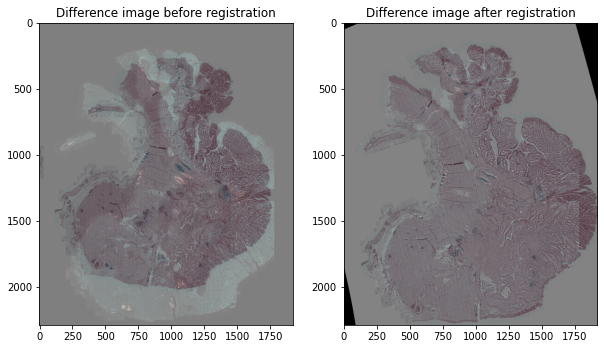

In [11]:
def histogram_mutual_information(image1, image2):
    hgram, x_edges, y_edges = np.histogram2d(image1.ravel(), image2.ravel(), bins=100)
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

I_t = torch.tensor(I).to(device) # without Gaussian
J_t = torch.tensor(J).to(device) # without Gaussian

params = ode_net()
Hr,Hi,Hinvr,Hinvi = ComplexMatrixExp(params[s].view(16,1,1))

if nChannel>1:
  J_w = PerspectiveComplexWarping(J_t.permute(2,0,1).unsqueeze(0), Hr,Hi, xy_lst[0][:,:,0], xy_lst[0][:,:,1]).squeeze().permute(1,2,0)
else:
  J_w = PerspectiveComplexWarping(J_t.unsqueeze(0).unsqueeze(0), Hr,Hi, xy_lst[0][:,:,0], xy_lst[0][:,:,1]).squeeze()

D = J_t - I_t
D_w = J_w - I_t

print("MI before registration:", histogram_mutual_information(I,J))
print("MI after registration:", histogram_mutual_information(I,J_w.cpu().detach().numpy()))

print("MSE before registration:", F.mse_loss(I_t,J_t).item())
print("MSE after registration:", F.mse_loss(I_t,J_w).item())

#print(H)

D = (D - torch.min(D))/(torch.max(D) - torch.min(D))
D_w = (D_w - torch.min(D_w))/(torch.max(D_w) - torch.min(D_w))
%matplotlib inline
fig=plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1)
plt.imshow(D.cpu().data)
plt.title("Difference image before registration")
fig.add_subplot(1,2,2)
plt.imshow(D_w.cpu().data)         
plt.title("Difference image after registration")